### XGBOOST 
Algoritmo:  XGBOOST
Variables:  dia, noche, festivos
SE probaron todas las otras variables, incluyendo info de la fecha, y destruían valor en los indicadores

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error


##  **1.  Cargamos la data**

In [8]:

df = pd.read_excel('DemandaCOES.xlsx', skiprows=3)
df = df[['FECHA','EJECUTADO']]
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%d/%m/%Y %H:%M')
# devolvemos todo 30 minutos para que asi no tengamos fechas del dia siguiente.
# antes del cambio  las 14:00 implicaban datos desde las 13:30 hasta las 14.  Luego del cambio significará desde las 14 hasta las 14:30
df['FECHA']= df['FECHA'] - pd.Timedelta(minutes=30)

df['mes'] = df['FECHA'].dt.month
df['ano'] = df['FECHA'].dt.year
df['diaDelAno'] = df['FECHA'].dt.day_of_year
df['diaDeLaSemana'] = df['FECHA'].dt.day_of_week
df['trimestre'] = df['FECHA'].dt.quarter
df['diaDelMes'] = df['FECHA'].dt.day

df = df.rename(columns={'FECHA':'fechaHora', 'EJECUTADO':'real'})

df['fecha'] = df['fechaHora'].dt.date
df['fecha'] = pd.to_datetime(df['fecha'])


df = df.dropna()

In [9]:
dfFestivos = pd.read_excel('Festivos peru.xlsx')
dfFestivos = dfFestivos[['diaYYYYMMDD']]
dfFestivos = dfFestivos.rename(columns ={'diaYYYYMMDD':'fecha'})
dfFestivos['fecha'] = pd.to_datetime(dfFestivos['fecha'], format='%Y%m%d')
dfFestivos['festivo'] = 1

In [10]:
df = df.merge(dfFestivos, on='fecha', how='left')
df['festivo'] = df['festivo'].fillna(0)
df['festivo'] = df['festivo'].astype(int)

In [11]:
dfBase = df[['real','mes','diaDelAno','diaDeLaSemana','trimestre','diaDelMes','festivo']].copy()
dfBase = dfBase.reset_index(drop=True)

In [14]:
def df_a_numpy(data1, historia, horizonte):
    X0,  y = [], [], [], []

    print('len data1:',len(data1))

    iMax = len(data1) - historia - horizonte

    for i in range(iMax+1):   # el for en python llega hasta iMax RECORDAR!!!
        X0.append(data1[i:i+historia])     # DIA.  OJO, LAS SERIES traen una menos del final
        y.append(data1[i+historia + horizonte])  # si horizo=0, se predice la Noche actual
    return np.array(X0),  np.array(y)




## **2.  CREAMOS 48 MODELOS**
Estos 48 modelos predicen 48 horas en el futuro.

In [16]:
# Definir los parámetros del modelo XGBoost
params = {
    'colsample_bytree':0.8,
    'learning_rate':0.1,
    'max_depth':5,
    'n_estimators': 400,
    'subsample':0.8
}

historia = 364   # un año de historia

listaModelos = []
listaYPred =[]
listaYTest = []

historia = 2*24*60  # 2 meses de historia

# maxHorizonte = 2*24  # mas bien vamos a predecir solo el siguiente dia 
maxHorizonte = 1
for horizonte in range(0, maxHorizonte):   # Horizonte dice a cuantos dias predecir

    print('horizonte:',horizonte)

    # Inicializar el regresor XGBoost
    regressor = xgb.XGBRegressor(**params)

    # OJO, LA ULTIMA FILA - HORIZONTE ES PARA PREDICCION!!
    # EL RESTO SI ES PARA TRAININ

    dfBaseReal = dfBase['real'].tolist()
    X0 , y = df_a_numpy(dfBaseReal, historia, horizonte) 
    X1 = dfBase.loc[historia + horizonte:, ['mes']] 
    X2 = df.loc[historia + horizonte:, ['diaDelAno']]
    X3 = df.loc[historia + horizonte:, ['diaDeLaSemana']]
    X4 = df.loc[historia + horizonte:, ['trimestre']]
    X5 = df.loc[historia + horizonte:, ['diaDelMes']]
    X6 = df.loc[historia + horizonte:, ['festivo']]

    X = np.concatenate((X0, X1, X2, X3, X4, X5, X6), axis=-1)

    totalFilas = len(X)
    totalEntrenamiento = (totalFilas*95)//100

    XTrain = X[:totalEntrenamiento, :]
    yTrain = y[:totalEntrenamiento]
    XTest = X[totalEntrenamiento:totalFilas-1, :]
    yTest = y[totalEntrenamiento:totalFilas-1]

    # Entrenamos
    regressor.fit(XTrain, yTrain)

    yPred = regressor.predict(XTest)
    # print('yPred:', len(yPred), yPred, yTest)

    plt.plot(yTest, label='Real')  # Graficar yTest en color azul
    plt.plot(yPred, label='Predicción')  # Graficar yPred en color naranja

    # Configurar etiquetas y leyenda
    plt.xlabel('Índice')  # Etiqueta del eje x
    plt.ylabel('Valor')  # Etiqueta del eje y
    plt.title('Horizonte:' + str(horizonte))  # Título del gráfico
    plt.legend()  # Mostrar leyenda

    # Mostrar el gráfico
    plt.show()

    listaModelos.append(regressor)
    listaYPred.append(yPred)
    listaYTest.append(yTest)
    

horizonte: 0


ValueError: too many values to unpack (expected 2)

## **2. Salvamos los modelos a disco**

In [171]:
# vamos a salvar los 90 modelos a disco
from joblib import dump

# Supongamos que tienes una lista llamada listaModelos que contiene modelos XGBRegressor

# Itera sobre la lista de modelos y guárdalos en disco
for i, modelo in enumerate(listaModelos):
    dump(modelo, f'modelo_{i}.joblib')

# modelo_i.joblib es el modelo que predice con un horizonte i, 
# desde 0 (o sea, predice el resultado de esta noche), hasta 90, es decir 
# predice 90 medias horas en el futuro o sea, casi 2 dias a futuro

## **3. Subimos los modelos a memoria**

In [174]:
# ahora vamos a cargar todos los modelos a memoria y usar el 0
from joblib import load

# Cargar los 91 modelos desde los archivos guardados
listaModelos = []
for i in range(91):
    modelo = load(f'modelo_{i}.joblib')
    listaModelos.append(modelo)


## **4. Ejemplo de uso de un modelo para predecir 90 medias horas a futuro**

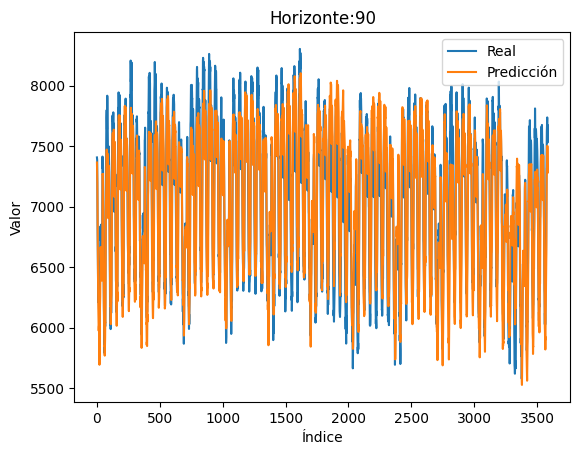

In [18]:
horizonte = 90
regressor = listaModelos[horizonte]
yPred = regressor.predict(XTest)
    # print('yPred:', len(yPred), yPred, yTest)

plt.plot(yTest, label='Real')  # Graficar yTest en color azul
plt.plot(yPred, label='Predicción')  # Graficar yPred en color naranja

# Configurar etiquetas y leyenda
plt.xlabel('Índice')  # Etiqueta del eje x
plt.ylabel('Valor')  # Etiqueta del eje y
plt.title('Horizonte:' + str(horizonte))  # Título del gráfico
plt.legend()  # Mostrar leyenda

# Mostrar el gráfico
plt.show()


## **4. todos los modelos se entrenaron con 364 dias de historia**

In [40]:
historia = 364   # un año de historia.  Así fueron entrenados los modelos
horizonte = 0
X0 , y = df_a_numpy(dfBase['real'], historia, horizonte) 

## **5. comparación fila en "y" versus en dfBase**

si **y** es un arreglo numpy, y[:10] traerá las filas desde el 0 hasta el 9, o sea 10 filas.

si **y** es un dataframe pandas y.loc[:10, :] traerá todas las filas desde la 0 hasta la 10, o sea 11 filas (con todas las columnas)

la equivalencia es por tanto:
**yNumpy[:i] == yDataFrame.loc[:i-1,:]**

In [47]:
n = 10
print('tamaños:', len(y[:n]),
      len(dfBase.loc[historia:historia + 10 -1, ['real']]))

print('primera fila:', y[0],
      dfBase.loc[historia:historia + 1 -1, ['real']])

print('ultima fila:', y[10],
      dfBase.loc[historia + 10:historia + 10, ['real']])

tamaños: 10 10
primera fila: 6907.6503           real
364  6907.6503
ultima fila: 6886.09628            real
374  6886.09628


## **6. predecimos un nuevo mes**
1.  llega un nuevo archivo.
2.  debemos leer al menos 364 medias horas hacia atras desde las 2pm del dia en cuestión
2.  Con eso, creamos XTest
3.  debemos predecir todo el mes y para eso debemos crear un XTest que tenga todos los datos requeridos desde el dia de hoy hasta el ultimo dia del mes


### **6.1 leemos DemandaCOES y Festivos y completamos columnas**
1. movemos todas las horas media hora atras, así que 1:30pm indica lo ocurrido entre la 1:30pm y las 2pm
2. creamos todas las columnas adicionales
3. eliminamos nulos
4. leemos festivos
5. unimos festivos a df para crear la columna festivo
6. Creamos dfBase que es df con solo las columnas que nos interesan

In [2]:
# 0.  leemos DemanddaCOES y SIMULAMOS QUE ES EL 1 DE MARZO DEL 2024 A LAS 2PM
df = pd.read_excel('DemandaCOES.xlsx', skiprows=3)
df = df[['FECHA','EJECUTADO']]
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%d/%m/%Y %H:%M')
df = df[df['FECHA']<= '2024-03-01 14:00:00']

# 1. media hora hacia atras
df['FECHA']= df['FECHA'] - pd.Timedelta(minutes=30)

# 2. nuevamos columnas
df['mes'] = df['FECHA'].dt.month
df['ano'] = df['FECHA'].dt.year
df['diaDelAno'] = df['FECHA'].dt.day_of_year
df['diaDeLaSemana'] = df['FECHA'].dt.day_of_week
df['trimestre'] = df['FECHA'].dt.quarter
df['diaDelMes'] = df['FECHA'].dt.day
df = df.rename(columns={'FECHA':'fechaHora', 'EJECUTADO':'real'})
df['fecha'] = df['fechaHora'].dt.date
df['fecha'] = pd.to_datetime(df['fecha'])

# 3. eliminamos nulos
df = df.dropna()

# 4. leemos festivos
dfFestivos = pd.read_excel('Festivos peru.xlsx')
dfFestivos = dfFestivos[['diaYYYYMMDD']]
dfFestivos = dfFestivos.rename(columns ={'diaYYYYMMDD':'fecha'})
dfFestivos['fecha'] = pd.to_datetime(dfFestivos['fecha'], format='%Y%m%d')
dfFestivos['festivo'] = 1

# 5. unimos festivos a df
df = df.merge(dfFestivos, on='fecha', how='left')
df['festivo'] = df['festivo'].fillna(0)
df['festivo'] = df['festivo'].astype(int)

# 6. creamos dfBase que es df con las columnas que nos interesan únicamente
dfBase = df[['real','mes','diaDelAno','diaDeLaSemana','trimestre','diaDelMes','festivo']].copy()
dfBase = dfBase.reset_index(drop=True)



## **6.1A:  cargamos los modelos**

In [5]:
# ahora vamos a cargar todos los modelos a memoria y usar el 0
from joblib import load

# Cargar los 91 modelos desde los archivos guardados
listaModelos = []
for i in range(91):
    modelo = load(f'modelo_{i}.joblib')
    listaModelos.append(modelo)

### **6.2 Acomodamos la data**
Lo que se debe hacer es generar la fila de las 2pm, uniendo 364 datos anteriores. y generar la predicción para esa fila con el modulo 0, que es las 14:00.

con esa predicción, se debe llenar ahora una nueva fila X

In [6]:
# 7. creamos la funcion que convierte dfBase a X SIN GENERAR Y
def df_a_numpy2(data1, historia, horizonte):
    X0,  y = [], []

    iMax = len(data1) - historia - horizonte 

    for i in range(iMax+1):   # el for en python llega hasta iMax RECORDAR!!!
        X0.append(data1[i:i+historia])     # DIA.  OJO, LAS SERIES traen una menos del final

    return np.array(X0)

In [7]:
historia = 364
horizonte = 0   

dfX = dfBase[-historia:].copy()

# este es el dia que vamos a calcular
fechaAnalisis = pd.to_datetime('2024-03-01 14:00:00')
X1 = [fechaAnalisis.month]

# esta es la historia (364 datos anteriores)
X0 = df_a_numpy2(dfX['real'], historia, horizonte)
X0 = X0.flatten()

X2 = [fechaAnalisis.day_of_year]
X3 = [fechaAnalisis.day_of_week]
X4 = [fechaAnalisis.quarter]
X5 = [fechaAnalisis.day]
X6 = [0]

print(X0.ndim,len(X1),len(X2),len(X3),len(X4),len(X5),len(X6))
if fechaAnalisis.floor('D') in dfFestivos['fecha'].values:
    print("La fechaAnalisis es un día festivo.")
    X6 = [1]

XTest = np.concatenate((X0, X1, X2, X3, X4, X5, X6), axis=-1)

# predecimos esta noche
horizonte = 0

# cargamos el modelo que predice esa noche
regressor = listaModelos[horizonte]
print('cargo el regressor')

yPred = regressor.predict(XTest)




1 1 1 1 1 1 1
cargo el regressor


XGBoostError: [11:49:46] /Users/runner/work/xgboost/xgboost/src/predictor/cpu_predictor.cc:719: Check failed: m->NumColumns() == model.learner_model_param->num_feature (1 vs. 2886) : Number of columns in data must equal to trained model.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000016c004994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000016c204e60 void xgboost::predictor::CPUPredictor::DispatchedInplacePredict<xgboost::data::ArrayAdapter, 64ul>(std::__1::any const&, std::__1::shared_ptr<xgboost::DMatrix>, xgboost::gbm::GBTreeModel const&, float, xgboost::PredictionCacheEntry*, unsigned int, unsigned int) const + 344
  [bt] (2) 3   libxgboost.dylib                    0x000000016c1fc068 xgboost::predictor::CPUPredictor::InplacePredict(std::__1::shared_ptr<xgboost::DMatrix>, xgboost::gbm::GBTreeModel const&, float, xgboost::PredictionCacheEntry*, unsigned int, unsigned int) const + 1572
  [bt] (3) 4   libxgboost.dylib                    0x000000016c12f108 xgboost::gbm::GBTree::InplacePredict(std::__1::shared_ptr<xgboost::DMatrix>, float, xgboost::PredictionCacheEntry*, int, int) const + 432
  [bt] (4) 5   libxgboost.dylib                    0x000000016c14d90c xgboost::LearnerImpl::InplacePredict(std::__1::shared_ptr<xgboost::DMatrix>, xgboost::PredictionType, float, xgboost::HostDeviceVector<float>**, int, int) + 164
  [bt] (5) 6   libxgboost.dylib                    0x000000016c0281d4 InplacePredictImpl(std::__1::shared_ptr<xgboost::DMatrix>, char const*, xgboost::Learner*, unsigned long long const**, unsigned long long*, float const**) + 276
  [bt] (6) 7   libxgboost.dylib                    0x000000016c028a88 XGBoosterPredictFromDense + 436
  [bt] (7) 8   libffi.dylib                        0x0000000196d74050 ffi_call_SYSV + 80
  [bt] (8) 9   libffi.dylib                        0x0000000196d7cae0 ffi_call_int + 1212

